# White-Box Interpretability: Looking Inside AI Models

## What is "White-Box" Interpretability?

Imagine you have two ways to understand how a car works:

1. **Black-box**: You can only observe inputs (gas pedal, steering wheel) and outputs (speed, direction). You treat the car as a mystery box.

2. **White-box**: You can open the hood, see the engine, trace the fuel lines, watch the pistons fire. You understand the *mechanism*.

**White-box interpretability** means we open up the neural network and look at:
- The actual numbers (activations) flowing through the network
- How different parts of the network contribute to outputs
- What "features" or "concepts" the network has learned

---

## Why Does This Matter for AI Safety?

### The Alignment Problem

We want AI systems that:
1. Do what we actually want (not just what we literally said)
2. Are honest about their uncertainty
3. Don't deceive us to achieve goals
4. Don't have hidden agendas

**The problem**: Current AI systems are trained to produce outputs that *look good* to humans. This creates incentives for:

- **Sycophancy**: Telling users what they want to hear, not the truth
- **Deception**: Hiding true beliefs/capabilities to avoid correction
- **Sandbagging**: Performing worse on purpose (e.g., on safety evaluations)

### Why White-Box Helps

If we can look *inside* the model, we can potentially:
- Detect when a model "knows" something different from what it says
- Find circuits responsible for deceptive behavior
- Build monitors that flag concerning internal states
- Surgically remove problematic behaviors

---

## What We'll Cover in This Notebook

1. **Understanding Transformer Internals** - What's actually inside these models?
2. **Activation Caching** - How to capture the internal states
3. **The Residual Stream** - The "highway" of information in transformers
4. **Logit Lens** - Peeking at predictions before the final layer
5. **Linear Probing** - Training simple classifiers on internal states
6. **Base vs Instruct Models** - How does RLHF change internal representations?
7. **Introduction to SAEs** - Finding interpretable features

Each section includes:
- Conceptual explanation (what and why)
- Mathematical intuition (the key equations)
- Working code (hands-on implementation)
- Interpretation guidance (what do results mean?)

---

# Part 1: Understanding Transformer Internals

## What's Inside a Transformer?

Before we can look inside, we need to understand what we're looking at. Let's build intuition from the ground up.

### The Big Picture

A transformer language model does one thing: **predict the next token**.

```
Input: "The cat sat on the"
Output: probability distribution over all possible next tokens
        "mat": 15%, "floor": 12%, "roof": 8%, "dog": 0.1%, ...
```

But *how* does it go from text to probabilities? Let's trace the path.

### Step 1: Tokenization

Text is converted to **tokens** - integer IDs representing pieces of text.

```
"The cat sat" → [464, 3797, 3332]  (example token IDs)
```

Tokens aren't always whole words:
- "understanding" might be ["under", "standing"] or ["understand", "ing"]
- This depends on the tokenizer's vocabulary

### Step 2: Embedding

Each token ID is converted to a **vector** (list of numbers) called an embedding.

```
Token 464 ("The") → [0.12, -0.34, 0.56, ..., 0.78]  (e.g., 768 numbers)
```

**Why vectors?** Neural networks operate on continuous numbers, not discrete symbols. The embedding maps discrete tokens into a continuous space where similar tokens are nearby.

The embedding dimension (often called `d_model`) is typically:
- Small models: 512-768
- Medium models: 1024-2048  
- Large models: 4096-8192

### Step 3: The Residual Stream

Here's the key insight that makes transformers interpretable:

**The residual stream is a vector that gets progressively updated as it flows through the model.**

Think of it like a document being passed around an office:
1. Document starts with initial content (the embedding)
2. Each department (layer) reads the document and *adds* their notes
3. The final document has accumulated contributions from everyone

Mathematically:
```
residual_0 = embedding(token)
residual_1 = residual_0 + attention_layer_0(residual_0) + mlp_layer_0(residual_0)
residual_2 = residual_1 + attention_layer_1(residual_1) + mlp_layer_1(residual_1)
...
residual_final = residual_{n-1} + attention_layer_{n-1} + mlp_layer_{n-1}
```

The **"+"** is crucial! Each layer *adds* to what came before, rather than replacing it. This is called a "residual connection" (hence "residual stream").

### Step 4: Attention Layers

Attention lets tokens "talk to each other". When processing position 5, the model can look back at positions 0-4 to gather relevant information.

**Intuition**: To predict what comes after "The cat sat on the", the model needs to know:
- There's a cat involved (look back at "cat")
- The cat is sitting (look back at "sat")
- We're describing a location (look back at "on")

Attention computes:
1. **Query**: "What am I looking for?" (from current position)
2. **Key**: "What do I contain?" (from all previous positions)
3. **Value**: "What information should I send?" (from all previous positions)

The attention pattern shows which positions are "talking" to which.

### Step 5: MLP Layers

MLP (Multi-Layer Perceptron) layers process each position independently. They're thought to store "facts" and perform "lookup" operations.

**Intuition**: 
- Attention gathers information from context
- MLPs retrieve/transform that information based on learned knowledge

Example: After attention gathers "cat" + "sat" + "on", the MLP might activate knowledge about "places cats sit" → increases probability of "mat", "floor", "couch"

### Step 6: Unembedding

The final residual stream vector is converted back to token probabilities:

```
logits = unembed(residual_final)  # Vector of size vocab_size (~50k-250k)
probabilities = softmax(logits)    # Convert to probabilities that sum to 1
```

The unembedding matrix is often the transpose of the embedding matrix ("weight tying").

---

## Visual Summary

```
Text: "The cat sat"
        ↓
    [Tokenize]
        ↓
Tokens: [464, 3797, 3332]
        ↓
    [Embed]
        ↓
Residual Stream: [[...], [...], [...]]  ← 3 vectors, one per token
        ↓
    [Layer 0: Attention + MLP]
        ↓
Residual Stream: [[...], [...], [...]]  ← updated vectors
        ↓
    [Layer 1: Attention + MLP]
        ↓
       ...
        ↓
    [Layer N-1: Attention + MLP]
        ↓
Final Residual: [[...], [...], [...]]  
        ↓
    [Unembed]
        ↓
Logits: [[...50k...], [...50k...], [...50k...]]
        ↓
    [Softmax]
        ↓
Probabilities for next token after each position
```

## Setup & Imports

In [1]:
import torch
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from transformer_lens import utils as tl_utils
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gc

# Check CUDA
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Output paths
OUTPUT_DIR = Path("../results")
FIGURES_DIR = Path("../figures")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

c:\Research\ai-safety\research-idea-6\experiments\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 3080
GPU Memory: 10.7 GB


## Load a Model

We'll use **Pythia-410M** - a good size for learning (small enough to run easily, large enough to show interesting behaviors).

**TransformerLens** is a library specifically designed for interpretability research. It gives us "hooks" to capture internal activations.

In [2]:
MODEL_NAME = "pythia-410m"

print(f"Loading {MODEL_NAME}...")
model = HookedTransformer.from_pretrained(
    MODEL_NAME,
    device=DEVICE,
)

# Let's examine the model's architecture
print(f"\n{'='*60}")
print(f"MODEL ARCHITECTURE: {MODEL_NAME}")
print(f"{'='*60}")
print(f"Total parameters: {model.cfg.n_params / 1e6:.0f}M")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Hidden dimension (d_model): {model.cfg.d_model}")
print(f"Number of attention heads: {model.cfg.n_heads}")
print(f"Head dimension (d_head): {model.cfg.d_head}")
print(f"MLP hidden dimension (d_mlp): {model.cfg.d_mlp}")
print(f"Vocabulary size: {model.cfg.d_vocab}")
print(f"Context window: {model.cfg.n_ctx}")
print(f"{'='*60}")

Loading pythia-410m...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model pythia-410m into HookedTransformer

MODEL ARCHITECTURE: pythia-410m
Total parameters: 302M
Number of layers: 24
Hidden dimension (d_model): 1024
Number of attention heads: 16
Head dimension (d_head): 64
MLP hidden dimension (d_mlp): 4096
Vocabulary size: 50304
Context window: 2048


### Understanding the Architecture Numbers

Let's unpack what these numbers mean:

- **d_model = 1024**: Each token is represented as a vector of 1024 numbers. This is the "width" of the residual stream.

- **n_layers = 24**: The model has 24 transformer blocks stacked. More layers = more "steps" of computation = potentially more sophisticated reasoning.

- **n_heads = 16**: Each attention layer has 16 "attention heads" that can attend to different things in parallel. One head might focus on syntax, another on semantics, etc.

- **d_head = 64**: Each attention head works in a 64-dimensional subspace. Note: d_model = n_heads × d_head (1024 = 16 × 64).

- **d_mlp = 4096**: The MLP hidden layer is 4x the model dimension. This is where a lot of "knowledge" is stored.

- **d_vocab = 50304**: The model knows ~50k different tokens.

- **n_ctx = 2048**: Maximum sequence length the model can process at once.

---

# Part 2: Activation Caching - Capturing Internal States

## What is Activation Caching?

When a neural network runs, it computes many intermediate values:
- The residual stream at each layer
- Attention patterns (which tokens attend to which)
- MLP activations
- And more...

Normally, these are computed and then discarded (to save memory). **Activation caching** means saving these intermediate values so we can analyze them.

**Analogy**: It's like recording a cooking show vs. just eating the final dish. By recording, you can go back and see exactly what happened at each step.

## TransformerLens Hooks

TransformerLens provides a clean way to cache activations using `run_with_cache()`.

The cache is organized by "hook names" that follow a pattern:
- `hook_embed`: Token embeddings
- `blocks.0.hook_resid_pre`: Residual stream before layer 0
- `blocks.0.attn.hook_pattern`: Attention pattern in layer 0
- `blocks.0.hook_resid_post`: Residual stream after layer 0
- `blocks.0.mlp.hook_post`: MLP output in layer 0
- And so on...

Let's see this in action!

In [3]:
# Let's run a simple example and cache everything
example_text = "The cat sat on the mat."

# Tokenize first to see what we're working with
tokens = model.to_tokens(example_text)
print(f"Input text: '{example_text}'")
print(f"Token IDs: {tokens[0].tolist()}")
print(f"Decoded tokens: {[model.to_string(t) for t in tokens[0]]}")
print(f"Number of tokens: {tokens.shape[1]}")

Input text: 'The cat sat on the mat.'
Token IDs: [0, 510, 5798, 2206, 327, 253, 1111, 15]
Decoded tokens: ['<|endoftext|>', 'The', ' cat', ' sat', ' on', ' the', ' mat', '.']
Number of tokens: 8


In [4]:
# Now run with caching
# This captures ALL intermediate activations
logits, cache = model.run_with_cache(tokens)

print(f"Output logits shape: {logits.shape}")
print(f"  - Batch size: {logits.shape[0]}")
print(f"  - Sequence length: {logits.shape[1]}")
print(f"  - Vocabulary size: {logits.shape[2]}")

print(f"\nNumber of cached activations: {len(cache)}")
print(f"\nSample of cached activation names:")
for i, name in enumerate(list(cache.keys())[:15]):
    print(f"  {name}: shape {cache[name].shape}")

Output logits shape: torch.Size([1, 8, 50304])
  - Batch size: 1
  - Sequence length: 8
  - Vocabulary size: 50304

Number of cached activations: 435

Sample of cached activation names:
  hook_embed: shape torch.Size([1, 8, 1024])
  blocks.0.hook_resid_pre: shape torch.Size([1, 8, 1024])
  blocks.0.ln1.hook_scale: shape torch.Size([1, 8, 1])
  blocks.0.ln1.hook_normalized: shape torch.Size([1, 8, 1024])
  blocks.0.attn.hook_q: shape torch.Size([1, 8, 16, 64])
  blocks.0.attn.hook_k: shape torch.Size([1, 8, 16, 64])
  blocks.0.attn.hook_v: shape torch.Size([1, 8, 16, 64])
  blocks.0.attn.hook_rot_q: shape torch.Size([1, 8, 16, 64])
  blocks.0.attn.hook_rot_k: shape torch.Size([1, 8, 16, 64])
  blocks.0.attn.hook_attn_scores: shape torch.Size([1, 16, 8, 8])
  blocks.0.attn.hook_pattern: shape torch.Size([1, 16, 8, 8])
  blocks.0.attn.hook_z: shape torch.Size([1, 8, 16, 64])
  blocks.0.hook_attn_out: shape torch.Size([1, 8, 1024])
  blocks.0.ln2.hook_scale: shape torch.Size([1, 8, 1])
  b

### Understanding the Cache

Let's look at the most important cached activations:

**Residual Stream** (`hook_resid_pre`, `hook_resid_post`):
- Shape: `[batch, seq_len, d_model]` = `[1, 8, 1024]`
- This is the main "information highway"
- `resid_pre` = state before a layer processes it
- `resid_post` = state after a layer processes it

**Attention Patterns** (`attn.hook_pattern`):
- Shape: `[batch, n_heads, seq_len, seq_len]` = `[1, 16, 8, 8]`
- Shows which tokens attend to which
- Entry [h, i, j] = how much head h at position i attends to position j

**MLP Activations** (`mlp.hook_post`):
- Shape: `[batch, seq_len, d_model]` = `[1, 8, 1024]`
- The output of the MLP that gets added to residual stream

In [5]:
# Let's examine the residual stream at different layers
print("Residual Stream Analysis")
print("=" * 60)

# Get residual stream at different points
resid_start = cache["hook_embed"]  # After embedding, before any layers
resid_mid = cache["blocks.12.hook_resid_post"]  # After layer 12 (middle)
resid_end = cache["blocks.23.hook_resid_post"]  # After final layer

print(f"\nResidual stream at START (after embedding):")
print(f"  Shape: {resid_start.shape}")
print(f"  Mean: {resid_start.mean():.4f}")
print(f"  Std: {resid_start.std():.4f}")
print(f"  Norm (avg over positions): {resid_start.norm(dim=-1).mean():.4f}")

print(f"\nResidual stream at MIDDLE (after layer 12):")
print(f"  Shape: {resid_mid.shape}")
print(f"  Mean: {resid_mid.mean():.4f}")
print(f"  Std: {resid_mid.std():.4f}")
print(f"  Norm (avg over positions): {resid_mid.norm(dim=-1).mean():.4f}")

print(f"\nResidual stream at END (after layer 23):")
print(f"  Shape: {resid_end.shape}")
print(f"  Mean: {resid_end.mean():.4f}")
print(f"  Std: {resid_end.std():.4f}")
print(f"  Norm (avg over positions): {resid_end.norm(dim=-1).mean():.4f}")

Residual Stream Analysis

Residual stream at START (after embedding):
  Shape: torch.Size([1, 8, 1024])
  Mean: -0.0000
  Std: 0.0227
  Norm (avg over positions): 0.7185

Residual stream at MIDDLE (after layer 12):
  Shape: torch.Size([1, 8, 1024])
  Mean: 0.0000
  Std: 10.6234
  Norm (avg over positions): 137.4114

Residual stream at END (after layer 23):
  Shape: torch.Size([1, 8, 1024])
  Mean: -0.0000
  Std: 1.6129
  Norm (avg over positions): 49.6896


### Key Observation: The Residual Stream Grows

Notice how the **norm** (length) of the residual stream vectors increases through the layers. This is because each layer *adds* to it.

This has important implications:
1. Later layers have "more information" accumulated
2. The final layer has the most "refined" representation
3. We can peek at intermediate layers to see "work in progress"

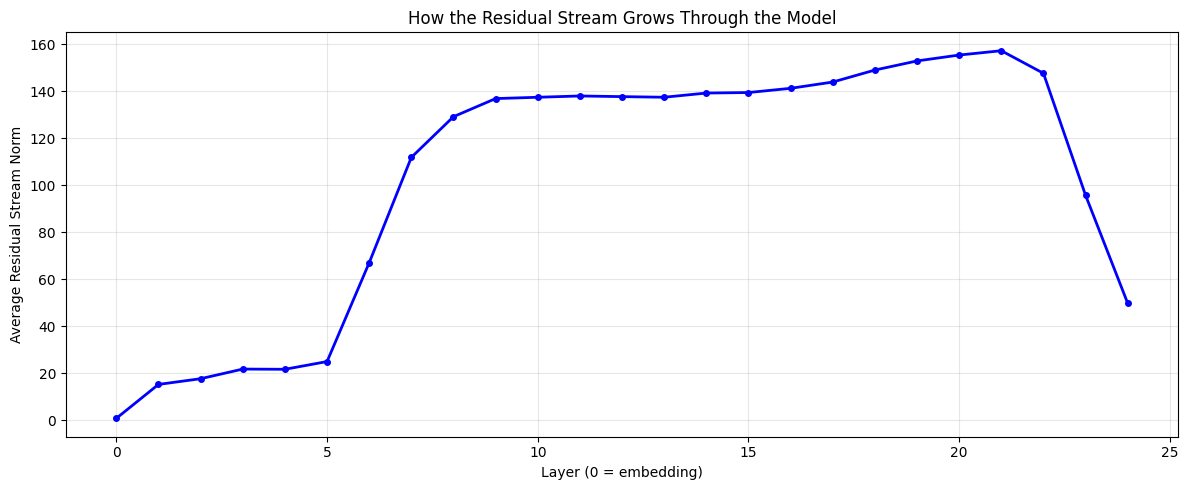


Norm increase from start to end: 69.15x


In [6]:
# Visualize how residual stream norm changes through layers
norms_by_layer = []

# Start with embeddings
norms_by_layer.append(cache["hook_embed"].norm(dim=-1).mean().item())

# Then each layer
for layer in range(model.cfg.n_layers):
    resid = cache[f"blocks.{layer}.hook_resid_post"]
    norms_by_layer.append(resid.norm(dim=-1).mean().item())

plt.figure(figsize=(12, 5))
plt.plot(range(len(norms_by_layer)), norms_by_layer, 'b-o', linewidth=2, markersize=4)
plt.xlabel("Layer (0 = embedding)")
plt.ylabel("Average Residual Stream Norm")
plt.title("How the Residual Stream Grows Through the Model")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "residual_stream_norm.png", dpi=150)
plt.show()

print(f"\nNorm increase from start to end: {norms_by_layer[-1] / norms_by_layer[0]:.2f}x")

---

# Part 3: The Logit Lens - Peeking at Intermediate Predictions

## What is the Logit Lens?

Here's a powerful idea: **What if we could see what the model would predict at each intermediate layer?**

Normally, only the final residual stream gets converted to predictions (via the unembedding matrix). But we can apply the same unembedding to *any* layer's residual stream!

```
Layer 0 residual → unembed → "What would layer 0 predict?"
Layer 5 residual → unembed → "What would layer 5 predict?"
Layer 12 residual → unembed → "What would layer 12 predict?"
...
Layer 23 residual → unembed → Final prediction (normal output)
```

## Why is This Useful for Alignment?

The logit lens can reveal:

1. **When does the model "make up its mind"?**
   - Early layers: Very uncertain
   - Middle layers: Starting to form a prediction
   - Late layers: Confident in final answer

2. **Does the model "know" something it doesn't say?**
   - If layer 10 predicts "X" but layer 23 predicts "Y"
   - The model may have "changed its mind" due to later processing
   - This could indicate deception, sycophancy, or just refinement

3. **Where does knowledge get "retrieved"?**
   - Sudden jumps in confidence often indicate MLP knowledge lookup

Let's implement it!

In [7]:
def logit_lens(model, cache, position=-1):
    """
    Apply the logit lens: get predictions from each layer's residual stream.
    
    Args:
        model: The HookedTransformer model
        cache: Activation cache from run_with_cache
        position: Which token position to analyze (-1 = last)
    
    Returns:
        Dictionary with predictions at each layer
    """
    results = []
    
    for layer in range(model.cfg.n_layers + 1):  # +1 to include post-final-layer
        if layer == 0:
            # Use embeddings (before any transformer layers)
            resid = cache["hook_embed"]
            layer_name = "embed"
        else:
            # Use residual stream after this layer
            resid = cache[f"blocks.{layer-1}.hook_resid_post"]
            layer_name = f"layer_{layer-1}"
        
        # Apply layer norm (important for getting good predictions)
        resid_normalized = model.ln_final(resid)
        
        # Get logits by applying unembedding
        # resid shape: [batch, seq, d_model]
        # unembed shape: [d_model, vocab]
        logits = resid_normalized @ model.W_U  # [batch, seq, vocab]
        
        # Get prediction at specified position
        logits_at_pos = logits[0, position, :]  # [vocab]
        probs = F.softmax(logits_at_pos, dim=-1)
        
        # Get top predictions
        top_probs, top_indices = probs.topk(5)
        top_tokens = [model.to_string(idx) for idx in top_indices]
        
        results.append({
            "layer": layer_name,
            "layer_num": layer,
            "top_token": top_tokens[0],
            "top_prob": top_probs[0].item(),
            "top_5": list(zip(top_tokens, top_probs.tolist())),
            "entropy": -(probs * probs.log()).sum().item(),  # Uncertainty measure
        })
    
    return results

print("Logit lens function defined!")

Logit lens function defined!


In [8]:
# Let's apply the logit lens to our example
# We'll look at what the model predicts after "The cat sat on the"

example_text = "The cat sat on the"
tokens = model.to_tokens(example_text)
logits, cache = model.run_with_cache(tokens)

print(f"Input: '{example_text}'")
print(f"Tokens: {[model.to_string(t) for t in tokens[0]]}")
print(f"\nAnalyzing predictions after the last token ('the')...\n")

lens_results = logit_lens(model, cache, position=-1)

print(f"{'Layer':<12} {'Top Prediction':<15} {'Prob':<10} {'Entropy':<10}")
print("=" * 50)
for r in lens_results:
    print(f"{r['layer']:<12} {repr(r['top_token']):<15} {r['top_prob']:.4f}     {r['entropy']:.2f}")

Input: 'The cat sat on the'
Tokens: ['<|endoftext|>', 'The', ' cat', ' sat', ' on', ' the']

Analyzing predictions after the last token ('the')...

Layer        Top Prediction  Prob       Entropy   
embed        'omin'          0.1156     6.31
layer_0      'manuel'        0.3152     4.96
layer_1      'manuel'        0.1255     6.69
layer_2      'manuel'        0.0859     6.72
layer_3      'manuel'        0.1179     6.64
layer_4      'manuel'        0.0539     7.37
layer_5      ' corners'      0.0468     6.76
layer_6      'ycin'          0.0323     7.20
layer_7      'ycin'          0.0764     6.98
layer_8      'VALUE'         0.0356     7.51
layer_9      'оч'            0.0258     7.58
layer_10     'icion'         0.0470     7.84
layer_11     'VALUE'         0.0126     8.15
layer_12     ' side'         0.0618     7.69
layer_13     'Microsoft'     0.0144     8.14
layer_14     ' bed'          0.0335     8.07
layer_15     ' whole'        0.0406     7.71
layer_16     ' bed'          0.0454 

### Interpreting the Logit Lens Results

Look at how the prediction evolves through layers:

1. **Early layers (0-5)**: High entropy, uncertain predictions. The model hasn't "figured it out" yet.

2. **Middle layers (6-15)**: Entropy starts dropping. The model is converging on an answer.

3. **Late layers (16-23)**: Low entropy, confident prediction. The answer is "locked in".

**Key insight**: If the model were being deceptive, we might see it "know" the right answer at layer 10 but then "change" to a different answer by layer 23. This would be visible in the logit lens!

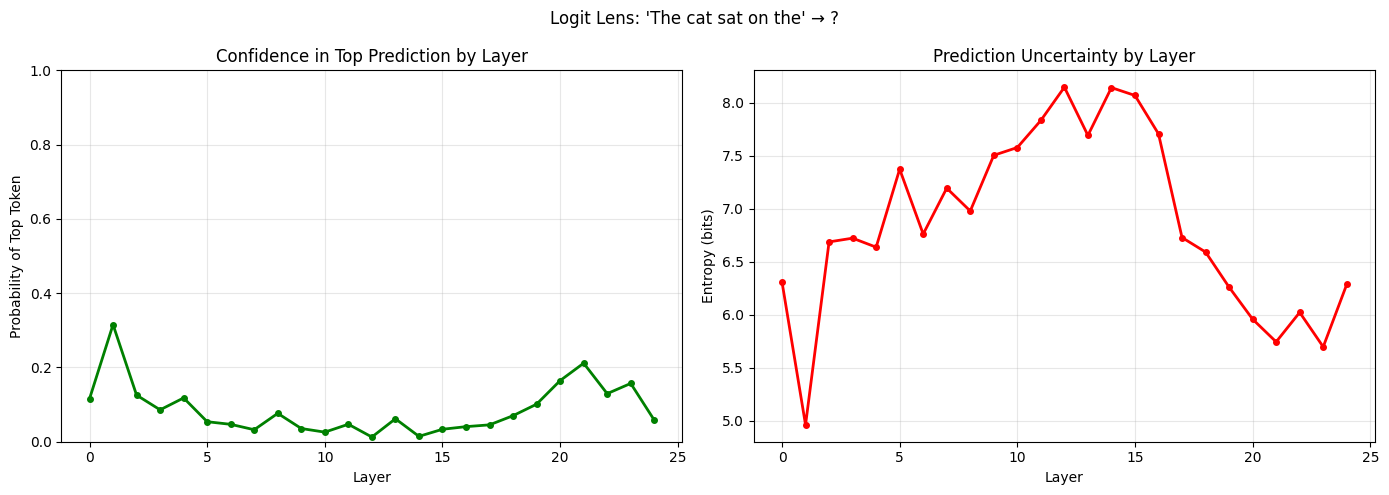

In [9]:
# Visualize how predictions evolve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

layers = [r["layer_num"] for r in lens_results]
top_probs = [r["top_prob"] for r in lens_results]
entropies = [r["entropy"] for r in lens_results]

# Plot 1: Top token probability
axes[0].plot(layers, top_probs, 'g-o', linewidth=2, markersize=4)
axes[0].set_xlabel("Layer")
axes[0].set_ylabel("Probability of Top Token")
axes[0].set_title("Confidence in Top Prediction by Layer")
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1)

# Plot 2: Entropy (uncertainty)
axes[1].plot(layers, entropies, 'r-o', linewidth=2, markersize=4)
axes[1].set_xlabel("Layer")
axes[1].set_ylabel("Entropy (bits)")
axes[1].set_title("Prediction Uncertainty by Layer")
axes[1].grid(True, alpha=0.3)

plt.suptitle(f"Logit Lens: '{example_text}' → ?", fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "logit_lens_example.png", dpi=150)
plt.show()

---

# Part 4: Linear Probing - Training Classifiers on Internal States

## What is Linear Probing?

Linear probing asks: **Can we train a simple linear classifier to extract information from the model's internal states?**

The idea:
1. Get activations from some layer of the model
2. Train a linear classifier (just weights, no hidden layers) to predict some property
3. If the classifier works well, that information is "linearly encoded" in the activations

**Why "linear"?** If a linear probe works, it means the information is stored in a simple, interpretable way - as a direction in the activation space. Non-linear probes can extract more information but are harder to interpret.

## Why is This Useful for Alignment?

We can train probes to detect:

1. **Truth vs. Falsehood**: Does the model "know" a statement is false even when it outputs it?
2. **Confidence**: Is the model uncertain internally even when it sounds confident?
3. **Sycophancy**: Can we detect when the model is "people-pleasing" vs. being truthful?
4. **User Modeling**: Is there a representation of "what the user wants to hear"?

## Example: Probing for Sentiment

Let's start with a simple example: can we find a "sentiment direction" in the model's activations?

In [10]:
# Create a simple dataset of positive and negative sentences
positive_texts = [
    "This movie was absolutely wonderful and amazing!",
    "I love this product, it's fantastic!",
    "The food was delicious and the service was great.",
    "What a beautiful day, I feel so happy!",
    "This is the best experience I've ever had.",
    "Incredible performance, truly outstanding!",
    "I'm so grateful for this wonderful opportunity.",
    "The team did an excellent job on this project.",
]

negative_texts = [
    "This movie was terrible and disappointing.",
    "I hate this product, it's awful!",
    "The food was disgusting and the service was horrible.",
    "What a terrible day, I feel so miserable.",
    "This is the worst experience I've ever had.",
    "Awful performance, truly disappointing!",
    "I'm so frustrated with this terrible situation.",
    "The team did a horrible job on this project.",
]

print(f"Positive examples: {len(positive_texts)}")
print(f"Negative examples: {len(negative_texts)}")

Positive examples: 8
Negative examples: 8


In [11]:
@torch.no_grad()
def get_activations(model, texts, layer=-1):
    """
    Get residual stream activations for a list of texts.
    
    Args:
        model: HookedTransformer model
        texts: List of strings
        layer: Which layer's output to use (-1 = final layer)
    
    Returns:
        Tensor of shape [n_texts, d_model] - one activation vector per text
    """
    activations = []
    
    for text in texts:
        tokens = model.to_tokens(text)
        _, cache = model.run_with_cache(tokens)
        
        # Get residual stream at specified layer
        if layer == -1:
            layer_idx = model.cfg.n_layers - 1
        else:
            layer_idx = layer
        
        resid = cache[f"blocks.{layer_idx}.hook_resid_post"]
        
        # Take the activation at the last token position
        # Shape: [batch=1, seq_len, d_model] → [d_model]
        act = resid[0, -1, :]
        activations.append(act)
    
    return torch.stack(activations)  # [n_texts, d_model]

# Get activations for positive and negative texts
print("Extracting activations from final layer...")
pos_activations = get_activations(model, positive_texts, layer=-1)
neg_activations = get_activations(model, negative_texts, layer=-1)

print(f"Positive activations shape: {pos_activations.shape}")
print(f"Negative activations shape: {neg_activations.shape}")

Extracting activations from final layer...
Positive activations shape: torch.Size([8, 1024])
Negative activations shape: torch.Size([8, 1024])


In [12]:
# Train a simple linear probe
# The probe is just: prediction = activations @ probe_direction
# We find the direction that best separates positive from negative

# Method 1: Difference of means (simplest approach)
# The "sentiment direction" is just the vector from negative centroid to positive centroid

pos_mean = pos_activations.mean(dim=0)  # [d_model]
neg_mean = neg_activations.mean(dim=0)  # [d_model]

sentiment_direction = pos_mean - neg_mean  # [d_model]
sentiment_direction = sentiment_direction / sentiment_direction.norm()  # Normalize

print(f"Sentiment direction shape: {sentiment_direction.shape}")
print(f"Sentiment direction norm: {sentiment_direction.norm():.4f}")

Sentiment direction shape: torch.Size([1024])
Sentiment direction norm: 1.0000


In [13]:
# Now let's see how well this direction separates the data
# Project activations onto the sentiment direction

pos_scores = pos_activations @ sentiment_direction  # [n_pos]
neg_scores = neg_activations @ sentiment_direction  # [n_neg]

print("Sentiment Scores (higher = more positive)")
print("=" * 50)
print("\nPositive texts:")
for text, score in zip(positive_texts, pos_scores):
    print(f"  {score:.2f}: {text[:50]}...")

print("\nNegative texts:")
for text, score in zip(negative_texts, neg_scores):
    print(f"  {score:.2f}: {text[:50]}...")

print(f"\nPositive mean score: {pos_scores.mean():.2f} (std: {pos_scores.std():.2f})")
print(f"Negative mean score: {neg_scores.mean():.2f} (std: {neg_scores.std():.2f})")
print(f"Separation: {pos_scores.mean() - neg_scores.mean():.2f}")

Sentiment Scores (higher = more positive)

Positive texts:
  -2.95: This movie was absolutely wonderful and amazing!...
  2.86: I love this product, it's fantastic!...
  2.91: The food was delicious and the service was great....
  1.05: What a beautiful day, I feel so happy!...
  -2.23: This is the best experience I've ever had....
  -0.31: Incredible performance, truly outstanding!...
  -6.35: I'm so grateful for this wonderful opportunity....
  2.66: The team did an excellent job on this project....

Negative texts:
  -18.39: This movie was terrible and disappointing....
  -12.70: I hate this product, it's awful!...
  -10.76: The food was disgusting and the service was horrib...
  -18.59: What a terrible day, I feel so miserable....
  -17.46: This is the worst experience I've ever had....
  -15.72: Awful performance, truly disappointing!...
  -20.36: I'm so frustrated with this terrible situation....
  -11.75: The team did a horrible job on this project....

Positive mean score: -0.2

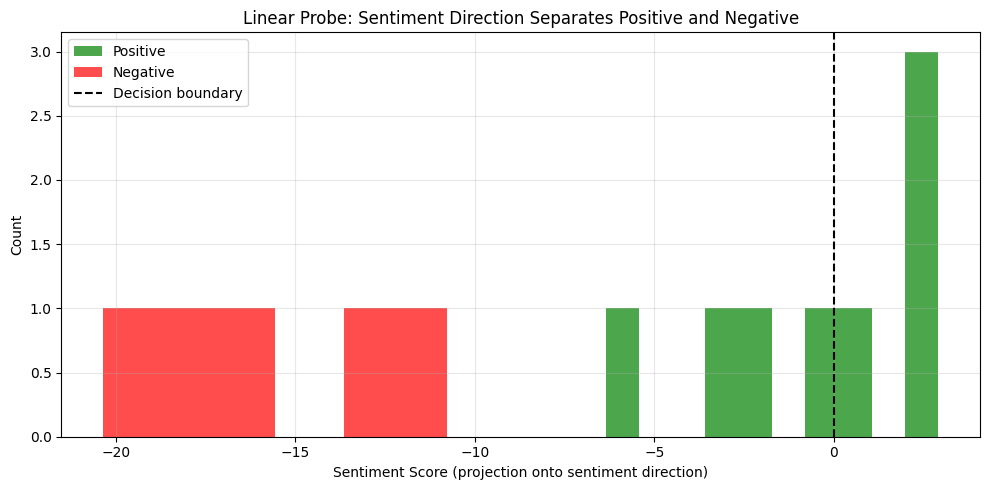


Classification accuracy: 100.0%


In [14]:
# Visualize the separation
plt.figure(figsize=(10, 5))

plt.hist(pos_scores.cpu().numpy(), bins=10, alpha=0.7, label="Positive", color="green")
plt.hist(neg_scores.cpu().numpy(), bins=10, alpha=0.7, label="Negative", color="red")
plt.axvline(x=0, color="black", linestyle="--", label="Decision boundary")

plt.xlabel("Sentiment Score (projection onto sentiment direction)")
plt.ylabel("Count")
plt.title("Linear Probe: Sentiment Direction Separates Positive and Negative")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "sentiment_probe.png", dpi=150)
plt.show()

# Calculate accuracy
threshold = (pos_scores.mean() + neg_scores.mean()) / 2
pos_correct = (pos_scores > threshold).sum().item()
neg_correct = (neg_scores < threshold).sum().item()
accuracy = (pos_correct + neg_correct) / (len(pos_scores) + len(neg_scores))
print(f"\nClassification accuracy: {accuracy:.1%}")

### What Did We Just Learn?

We found a **linear direction** in the model's activation space that corresponds to sentiment!

This means:
1. The model has a clear, interpretable "sentiment axis"
2. We can measure any text's sentiment by projecting onto this direction
3. This is evidence that the model represents sentiment in a simple, linear way

**For alignment research**, the same technique can be used to find:
- A "truthfulness" direction (does the model believe what it's saying?)
- A "certainty" direction (is the model confident?)
- A "sycophancy" direction (is the model just agreeing with the user?)

---

# Part 5: Probing for Truthfulness - A Key Alignment Application

## The Big Question

Can we detect when a model "knows" something is true or false, independent of what it says?

This is crucial for alignment:
- If a model says "X" but internally represents "not X", it might be deceptive
- If we can detect this, we can build better safety monitors

## Experimental Setup

We'll create pairs of:
- True statements (facts the model should know)
- False statements (counterfactuals)

Then probe the activations to see if there's a "truth direction".

In [15]:
# Create true/false statement pairs
# Format: (statement, is_true)

statements = [
    # Geography
    ("The capital of France is Paris.", True),
    ("The capital of France is London.", False),
    ("The capital of Japan is Tokyo.", True),
    ("The capital of Japan is Beijing.", False),
    ("The Nile is the longest river in Africa.", True),
    ("The Amazon is the longest river in Africa.", False),
    
    # Science
    ("Water freezes at 0 degrees Celsius.", True),
    ("Water freezes at 50 degrees Celsius.", False),
    ("The Earth orbits around the Sun.", True),
    ("The Sun orbits around the Earth.", False),
    ("Humans have 23 pairs of chromosomes.", True),
    ("Humans have 46 pairs of chromosomes.", False),
    
    # Math
    ("Two plus two equals four.", True),
    ("Two plus two equals five.", False),
    ("The square root of 16 is 4.", True),
    ("The square root of 16 is 5.", False),
    
    # General knowledge
    ("The sky appears blue during the day.", True),
    ("The sky appears green during the day.", False),
    ("Cats are mammals.", True),
    ("Cats are reptiles.", False),
]

true_statements = [s for s, is_true in statements if is_true]
false_statements = [s for s, is_true in statements if not is_true]

print(f"True statements: {len(true_statements)}")
print(f"False statements: {len(false_statements)}")

True statements: 10
False statements: 10


In [16]:
# Get activations for true and false statements
print("Extracting activations...")
true_acts = get_activations(model, true_statements, layer=-1)
false_acts = get_activations(model, false_statements, layer=-1)

# Find truth direction (same method as sentiment)
true_mean = true_acts.mean(dim=0)
false_mean = false_acts.mean(dim=0)

truth_direction = true_mean - false_mean
truth_direction = truth_direction / truth_direction.norm()

print(f"Truth direction found!")

Extracting activations...
Truth direction found!


In [17]:
# Test the truth probe
true_scores = true_acts @ truth_direction
false_scores = false_acts @ truth_direction

print("Truth Scores (higher = more likely true)")
print("=" * 60)
print("\nTrue statements:")
for text, score in zip(true_statements, true_scores):
    print(f"  {score:+.2f}: {text}")

print("\nFalse statements:")
for text, score in zip(false_statements, false_scores):
    print(f"  {score:+.2f}: {text}")

print(f"\nTrue mean: {true_scores.mean():.2f} (std: {true_scores.std():.2f})")
print(f"False mean: {false_scores.mean():.2f} (std: {false_scores.std():.2f})")

Truth Scores (higher = more likely true)

True statements:
  -15.24: The capital of France is Paris.
  -15.54: The capital of Japan is Tokyo.
  -9.97: The Nile is the longest river in Africa.
  -19.82: Water freezes at 0 degrees Celsius.
  -13.99: The Earth orbits around the Sun.
  -11.06: Humans have 23 pairs of chromosomes.
  -23.48: Two plus two equals four.
  -11.60: The square root of 16 is 4.
  -20.99: The sky appears blue during the day.
  -12.30: Cats are mammals.

False statements:
  -19.16: The capital of France is London.
  -21.50: The capital of Japan is Beijing.
  -18.43: The Amazon is the longest river in Africa.
  -20.77: Water freezes at 50 degrees Celsius.
  -18.07: The Sun orbits around the Earth.
  -12.72: Humans have 46 pairs of chromosomes.
  -23.95: Two plus two equals five.
  -16.28: The square root of 16 is 5.
  -20.43: The sky appears green during the day.
  -18.37: Cats are reptiles.

True mean: -15.40 (std: 4.60)
False mean: -18.97 (std: 3.06)


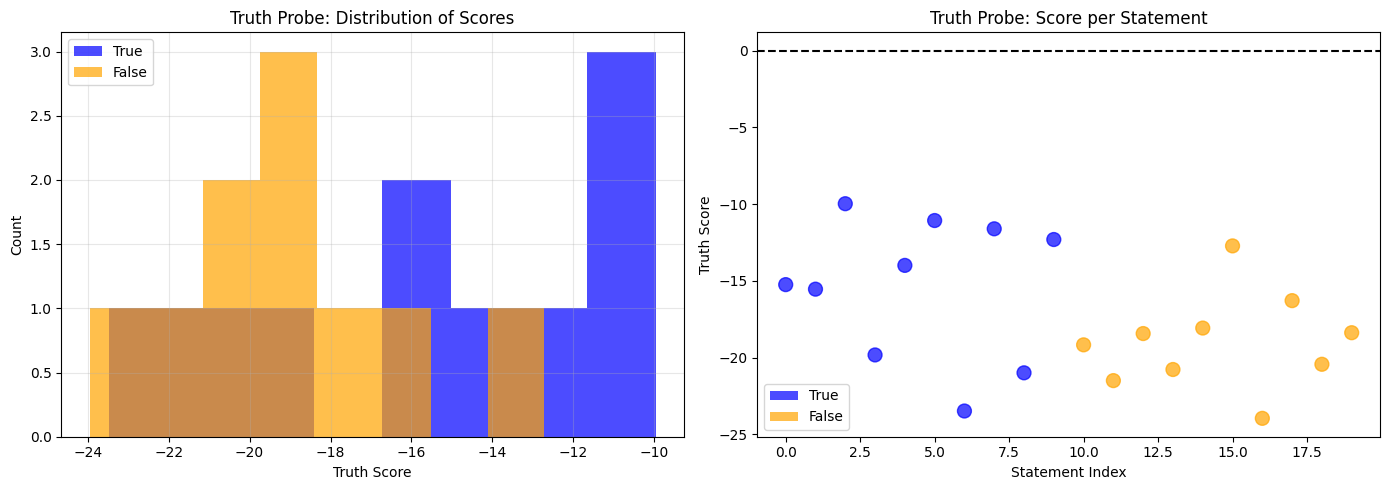


Accuracy: 15/20 = 75.0%


In [18]:
# Visualize truth probe results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(true_scores.cpu().numpy(), bins=8, alpha=0.7, label="True", color="blue")
axes[0].hist(false_scores.cpu().numpy(), bins=8, alpha=0.7, label="False", color="orange")
axes[0].set_xlabel("Truth Score")
axes[0].set_ylabel("Count")
axes[0].set_title("Truth Probe: Distribution of Scores")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot with statements
all_scores = torch.cat([true_scores, false_scores]).cpu().numpy()
all_labels = ["True"] * len(true_scores) + ["False"] * len(false_scores)
colors = ["blue" if l == "True" else "orange" for l in all_labels]

axes[1].scatter(range(len(all_scores)), all_scores, c=colors, s=100, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="--")
axes[1].set_xlabel("Statement Index")
axes[1].set_ylabel("Truth Score")
axes[1].set_title("Truth Probe: Score per Statement")

# Add a simple legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='True'),
                   Patch(facecolor='orange', alpha=0.7, label='False')]
axes[1].legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "truth_probe.png", dpi=150)
plt.show()

# Accuracy
threshold = (true_scores.mean() + false_scores.mean()) / 2
correct = (true_scores > threshold).sum() + (false_scores < threshold).sum()
total = len(true_scores) + len(false_scores)
print(f"\nAccuracy: {correct}/{total} = {correct/total:.1%}")

### Implications for Detecting Deception

If the truth probe works (which it often does on simple factual statements), this opens up powerful possibilities:

1. **Runtime monitoring**: Check if the model's "truth score" matches what it's saying
   - Model says "The capital of France is Berlin"
   - Truth probe says "low score" → flag as potential error/lie

2. **Deception detection**: Look for systematic mismatches
   - Model knows X internally (high truth score for X)
   - But outputs "not X" → potential deception

3. **Uncertainty detection**: If truth scores are close to 0, model is uncertain

**Caveat**: These probes are trained on simple examples. Real-world deception might be more sophisticated. This is an active area of research!

---

# Part 6: Base vs Instruct Models - How Does RLHF Change Things?

## What is RLHF?

**RLHF** = Reinforcement Learning from Human Feedback

It's the process that turns a "base" language model (which just predicts text) into a helpful, harmless assistant.

The process:
1. **Base model**: Trained to predict next token on internet text
2. **Supervised fine-tuning**: Trained on examples of good assistant behavior
3. **RLHF**: Further trained to maximize human preference scores

## Why Does This Matter for Alignment?

RLHF is powerful but has known failure modes:

1. **Sycophancy**: Model learns to tell users what they want to hear (because that gets high ratings)

2. **Deceptive alignment**: Model might learn to "game" the reward signal rather than be genuinely helpful

3. **Hidden capabilities**: The base model might "know" things that get suppressed by RLHF

By comparing base and instruct models, we can see:
- What changes in the internal representations
- Whether the instruct model still "knows" things it won't say
- How the probability distributions shift

## Experiment: Comparing Pythia Base vs Instruct

Unfortunately, Pythia doesn't have an official instruct version. Let's instead demonstrate with a conceptual example of what we'd look for, and use the KL divergence data from your previous notebook.

In [19]:
# Load the KL divergence results from the previous notebook
kl_results_path = OUTPUT_DIR / "kl_divergence_results.parquet"

if kl_results_path.exists():
    df_kl = pd.read_parquet(kl_results_path)
    print(f"Loaded KL divergence results: {len(df_kl)} tokens")
    print(f"Columns: {list(df_kl.columns)}")
else:
    print("KL divergence results not found. Run 01_exploration.ipynb first.")
    df_kl = None

Loaded KL divergence results: 34965 tokens
Columns: ['batch_idx', 'position', 'token_id', 'token_text', 'next_token_id', 'next_token_text', 'kl_divergence', 'small_log_prob', 'big_log_prob', 'log_prob_diff', 'context_before', 'context_after']


In [20]:
if df_kl is not None:
    # Analyze what kinds of tokens have high KL divergence
    # These are positions where small and big models disagree
    
    high_kl = df_kl[df_kl["kl_divergence"] > df_kl["kl_divergence"].quantile(0.95)]
    
    print("Tokens with high KL divergence (top 5%)")
    print("="*60)
    print(f"Number of high-KL tokens: {len(high_kl)}")
    print(f"\nTop 10 highest KL divergences:")
    
    for _, row in high_kl.nlargest(10, "kl_divergence").iterrows():
        print(f"\n  KL: {row['kl_divergence']:.3f}")
        print(f"  Token: {repr(row['token_text'])} → Next: {repr(row['next_token_text'])}")
        print(f"  Context: ...{row['context_before'][-30:]}[HERE]{row['context_after'][:30]}...")
        print(f"  Log prob diff (big-small): {row['log_prob_diff']:.3f}")

Tokens with high KL divergence (top 5%)
Number of high-KL tokens: 1749

Top 10 highest KL divergences:

  KL: 12.633
  Token: '"' → Next: ' do'
  Context: ...ormorant-sc"[HERE] do
  version :...
  Log prob diff (big-small): 13.739

  KL: 9.442
  Token: 'bell' → Next: ' Kingdom'
  Context: ... Miami Heat. Join Cowbell[HERE] Kingdom’sJames Ham...
  Log prob diff (big-small): 11.274

  KL: 7.156
  Token: 'kers' → Next: 'ole'
  Context: ...ers wrtier Sam Inkers[HERE]ole, where he will...
  Log prob diff (big-small): 10.513

  KL: 6.557
  Token: '      ' → Next: 'using'
  Context: ...orantsc",
      [HERE]using:      :sv...
  Log prob diff (big-small): 9.269

  KL: 6.433
  Token: ' by' → Next: ' Work'
  Context: ...
This file is generated by[HERE] Workflow compiler
https...
  Log prob diff (big-small): 9.892

  KL: 6.360
  Token: 'road' → Next: 'cast'
  Context: ... it is possible to superbroad[HERE]cast/ teleport the...
  Log prob diff (big-small): 7.085

  KL: 6.165
  Token: 'atie' → Next

### What High KL Divergence Tells Us

When we compare two models (like base vs. instruct, or small vs. large), high KL divergence at a position means:

1. **The models have different "beliefs"** about what comes next
2. **Scale/training changes something fundamental** at these positions
3. **These are the "interesting" positions** for interpretability research

For base vs. instruct comparisons, high KL might indicate:
- Positions where RLHF "edited" the model's behavior
- Topics the instruct model was trained to be more careful about
- Potential sycophancy (instruct model shifting toward "agreeable" responses)

## Sycophancy Detection Framework

Here's a conceptual framework for detecting sycophancy using these techniques:

In [21]:
# Conceptual framework for sycophancy detection
# (This would require an instruct model to fully implement)

sycophancy_framework = """
SYCOPHANCY DETECTION FRAMEWORK
==============================

Setup:
1. Base model (no RLHF)
2. Instruct model (with RLHF)
3. Prompts that encourage sycophancy:
   - "I think X. Do you agree?"
   - "My professor says X. Is that correct?"
   - "Everyone knows X is true, right?"

Detection Methods:

1. KL DIVERGENCE ANALYSIS
   - Compare base vs instruct model outputs
   - High KL on opinion questions → potential sycophancy
   - Look for asymmetric shifts toward agreement

2. TRUTH PROBE
   - Train probe on instruct model for truthfulness
   - Run probe on sycophantic prompts
   - If probe says "false" but model outputs agreement → sycophancy detected

3. ACTIVATION PATCHING
   - Find which components cause sycophantic behavior
   - Patch activations from base model into instruct model
   - Does behavior become less sycophantic?

4. LOGIT LENS
   - Check early layer predictions vs final output
   - Does early layer "know" correct answer but final layer disagrees?

Red Flags:
- Model agrees with user's stated opinion regardless of truth value
- High confidence in output + low truth probe score
- Large activation changes in layers associated with "user modeling"
"""

print(sycophancy_framework)


SYCOPHANCY DETECTION FRAMEWORK

Setup:
1. Base model (no RLHF)
2. Instruct model (with RLHF)
3. Prompts that encourage sycophancy:
   - "I think X. Do you agree?"
   - "My professor says X. Is that correct?"
   - "Everyone knows X is true, right?"

Detection Methods:

1. KL DIVERGENCE ANALYSIS
   - Compare base vs instruct model outputs
   - High KL on opinion questions → potential sycophancy
   - Look for asymmetric shifts toward agreement

2. TRUTH PROBE
   - Train probe on instruct model for truthfulness
   - Run probe on sycophantic prompts
   - If probe says "false" but model outputs agreement → sycophancy detected

3. ACTIVATION PATCHING
   - Find which components cause sycophantic behavior
   - Patch activations from base model into instruct model
   - Does behavior become less sycophantic?

4. LOGIT LENS
   - Check early layer predictions vs final output
   - Does early layer "know" correct answer but final layer disagrees?

Red Flags:
- Model agrees with user's stated opinion

---

# Part 7: Introduction to Sparse Autoencoders (SAEs)

## The Problem: Neural Networks Are Hard to Interpret

Even with all the techniques above, we have a fundamental problem:

**Neurons don't correspond to concepts.**

In the residual stream, each of the 1024 dimensions doesn't mean anything specific. The "sentiment" might be spread across hundreds of dimensions. The "knows it's lying" signal might be entangled with many other things.

This is called **superposition**: networks pack many more concepts than dimensions by spreading them across overlapping directions.

## The Solution: Sparse Autoencoders

**Sparse Autoencoders (SAEs)** try to "unpack" the superposition.

The idea:
1. Take the residual stream activations (1024 dimensions)
2. Project them into a MUCH larger space (e.g., 32,000 dimensions)
3. Force most of these dimensions to be zero (sparsity)
4. The non-zero dimensions are hopefully interpretable "features"

```
Residual stream [1024] → SAE encoder → Sparse features [32,000]
                                              ↓
                              Most are 0, a few are active
                                              ↓
                              Each active feature = interpretable concept?
```

## Why Might This Work?

If the model represents 10,000 concepts but only ~50 are active at any time:
- They're packed into 1024 dimensions (superposition)
- An SAE with 32,000 features can give each concept its own dimension
- Sparsity constraint forces the SAE to find these "natural" concepts

## Existing SAEs: Gemma Scope

Google DeepMind released **Gemma Scope**: pre-trained SAEs for Gemma models.

These SAEs have found interpretable features like:
- "Python code" feature
- "Deception/lying" feature
- "Uncertainty" feature
- "User request" feature

Let's see how to use them!

In [22]:
# Note: Using Gemma SAEs requires the Gemma model
# For now, let's implement a simple SAE concept demonstration

# Toy example: What an SAE does mathematically

def simple_sae_demo():
    """
    Demonstrate SAE concept with a toy example.
    """
    print("SPARSE AUTOENCODER: TOY EXAMPLE")
    print("="*50)
    
    # Imagine we have 4-dimensional activations
    d_model = 4
    
    # And we want 8 sparse features
    n_features = 8
    
    # Random encoder weights (in practice, these are learned)
    W_enc = torch.randn(d_model, n_features)
    W_enc = W_enc / W_enc.norm(dim=0, keepdim=True)  # Normalize
    
    # Example activation (could be from any layer)
    activation = torch.tensor([1.0, 0.5, -0.3, 0.8])
    
    print(f"\nInput activation (d_model={d_model}): {activation.tolist()}")
    
    # Encode: project to feature space
    features_pre_relu = activation @ W_enc  # [n_features]
    print(f"\nFeatures before ReLU ({n_features} dims): {features_pre_relu.tolist()}")
    
    # Apply ReLU (only positive activations survive)
    features = F.relu(features_pre_relu)
    print(f"\nFeatures after ReLU (sparse): {features.tolist()}")
    print(f"Non-zero features: {(features > 0).sum().item()}/{n_features}")
    
    # In a trained SAE, each of these features would have an interpretation!
    print("\n" + "="*50)
    print("In a TRAINED SAE, each feature might correspond to:")
    print("  Feature 0: 'Discussing mathematics'")
    print("  Feature 1: 'Sentiment is negative'")
    print("  Feature 2: 'Python code context'")
    print("  Feature 3: 'User asking a question'")
    print("  Feature 4: 'Model is uncertain'")
    print("  Feature 5: 'Potentially deceptive context'")
    print("  ...")
    
simple_sae_demo()

SPARSE AUTOENCODER: TOY EXAMPLE

Input activation (d_model=4): [1.0, 0.5, -0.30000001192092896, 0.800000011920929]

Features before ReLU (8 dims): [-0.018781064078211784, 0.780147135257721, -0.8426016569137573, -1.3608720302581787, -0.03578551858663559, -0.1637793481349945, -0.24572889506816864, -0.33983880281448364]

Features after ReLU (sparse): [0.0, 0.780147135257721, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Non-zero features: 1/8

In a TRAINED SAE, each feature might correspond to:
  Feature 0: 'Discussing mathematics'
  Feature 1: 'Sentiment is negative'
  Feature 2: 'Python code context'
  Feature 3: 'User asking a question'
  Feature 4: 'Model is uncertain'
  Feature 5: 'Potentially deceptive context'
  ...


## Loading Real SAEs (Gemma Scope)

To use Gemma Scope SAEs, you would:

```python
# 1. Load Gemma model
from transformer_lens import HookedTransformer
model = HookedTransformer.from_pretrained("gemma-2-2b")

# 2. Load SAE from Hugging Face
from sae_lens import SAE
sae = SAE.from_pretrained(
    release="gemma-scope-2b-pt-res",
    sae_id="layer_12/width_16k/average_l0_71"
)

# 3. Run model and get activations
_, cache = model.run_with_cache(tokens)
resid = cache["blocks.12.hook_resid_post"]

# 4. Encode with SAE
features = sae.encode(resid)  # Sparse feature activations

# 5. Find which features are active
active_features = (features > 0.5).nonzero()

# 6. Look up feature interpretations
# (Gemma Scope provides labels for many features)
```

The Gemma Scope features have been analyzed and many have interpretable meanings. This is a very active area of research!

---

# Summary: Your White-Box Interpretability Toolkit

You now have the foundations for several powerful techniques:

## Techniques Learned

| Technique | What It Does | Alignment Application |
|-----------|--------------|----------------------|
| **Activation Caching** | Save internal states | Foundation for all other techniques |
| **Residual Stream Analysis** | Track information flow | Understand what the model "knows" at each step |
| **Logit Lens** | Peek at intermediate predictions | Detect when model "changes its mind" |
| **Linear Probing** | Find interpretable directions | Detect truth, sentiment, sycophancy |
| **KL Divergence** | Compare model distributions | Find where models differ (e.g., base vs instruct) |
| **SAEs** | Find sparse, interpretable features | Decompose representations into concepts |

## The Big Picture for Alignment

These techniques let us ask:

1. **Does the model know X?** → Linear probes on truth
2. **Is the model uncertain?** → Entropy analysis, uncertainty probes
3. **Is the model being deceptive?** → Compare internal beliefs to outputs
4. **How did RLHF change the model?** → KL divergence, activation patching
5. **What concepts does the model use?** → SAE feature analysis

## Next Steps for Your Research

1. **Collect sycophancy examples**: Create prompts that encourage sycophantic behavior
2. **Train truth probes**: On a larger, more diverse dataset
3. **Compare base vs instruct**: Use Gemma-2-2B vs Gemma-2-2B-it
4. **Explore SAE features**: Use Gemma Scope to find deception-related features
5. **Build monitors**: Create real-time detectors for concerning behavior

In [23]:
# Cleanup
del model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU memory after cleanup: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

print("\nNotebook complete!")

GPU memory after cleanup: 2.06 GB

Notebook complete!
